<a href="https://colab.research.google.com/github/BhaveshNikam09/CNN-Image-Classifier-with-DVC/blob/main/self_driving_car.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install roboflow
!pip install torch torchvision torchaudio
!pip install git+https://github.com/facebookresearch/detectron2.git

In [1]:
from roboflow import Roboflow
rf = Roboflow(api_key="o0qlzMSdjo45PEreymoH")
project = rf.workspace("roboflow-gw7yv").project("self-driving-car")
version = project.version(3)
dataset = version.download("coco")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 80.8 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Self-Driving-Car-3 in coco:: 100%|██████████| 29804/29804 [00:06<00:00, 4850.89it/s]


In [1]:
from detectron2.data.datasets import register_coco_instances

register_coco_instances(
    "self-car",
    {},
    "/content/Self-Driving-Car-3/export/_annotations.coco.json",
    "/content/Self-Driving-Car-3/export"

)


In [2]:
from detectron2.data import MetadataCatalog,DatasetCatalog

dataset_dict=DatasetCatalog.get('self-car')
metadata=MetadataCatalog.get('self-car')

Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



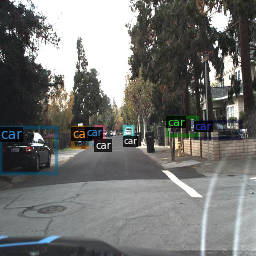

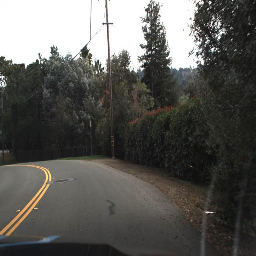

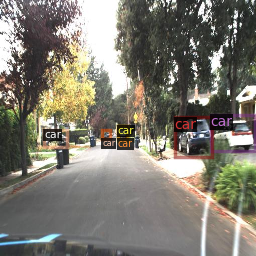

In [6]:
import random
from detectron2.utils.visualizer import Visualizer
from google.colab.patches import cv2_imshow
import cv2

for d in random.sample(dataset_dict, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

In [10]:
from detectron2.engine import DefaultTrainer
from detectron2 import model_zoo
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("self-car",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 3000   # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 12  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[04/13 15:29:17 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:00, 187MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[04/13 15:29:22 d2.engine.train_loop]: Starting training from iteration 0
[04/13 15:29:28 d2.utils.events]:  eta: 0:14:12  iter: 19  total_loss: 3.706  loss_cls: 2.657  loss_box_reg: 0.8684  loss_rpn_cls: 0.05198  loss_rpn_loc: 0.06379    time: 0.2842  last_time: 0.2326  data_time: 0.0134  last_data_time: 0.0049   lr: 4.9953e-06  max_mem: 2908M
[04/13 15:29:34 d2.utils.events]:  eta: 0:14:53  iter: 39  total_loss: 3.489  loss_cls: 2.55  loss_box_reg: 0.8403  loss_rpn_cls: 0.0448  loss_rpn_loc: 0.07203    time: 0.2974  last_time: 0.3101  data_time: 0.0054  last_data_time: 0.0049   lr: 9.9902e-06  max_mem: 2911M
[04/13 15:29:41 d2.utils.events]:  eta: 0:14:52  iter: 59  total_loss: 3.327  loss_cls: 2.334  loss_box_reg: 0.8545  loss_rpn_cls: 0.05074  loss_rpn_loc: 0.07625    time: 0.3003  last_time: 0.3133  data_time: 0.0050  last_data_time: 0.0045   lr: 1.4985e-05  max_mem: 2911M
[04/13 15:29:47 d2.utils.events]:  eta: 0:14:48  iter: 79  total_loss: 2.871  loss_cls: 2.01  loss_box_reg: 0

In [ ]:
from detectron2.data import DatasetCatalog
print("Sample dict:", DatasetCatalog.get("self_carexport")[0])

Sample dict: {'file_name': '/content/Self-Driving-Car-3/export/1478897026627294725_jpg.rf.6828a4e821cbab4c2c277d74df291f00.jpg', 'image_id': 0, 'height': 512, 'width': 512, 'annotations': [{'bbox': [140, 262, 21, 25.5], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'segmentation': [], 'category_id': 2}, {'bbox': [266, 231, 24, 95.5], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'segmentation': [], 'category_id': 2}, {'bbox': [271, 241, 17, 76], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'segmentation': [], 'category_id': 2}, {'bbox': [280, 220, 89.5, 121], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'segmentation': [], 'category_id': 2}]}


In [12]:
from detectron2.engine import DefaultPredictor
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)


[04/13 15:45:48 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


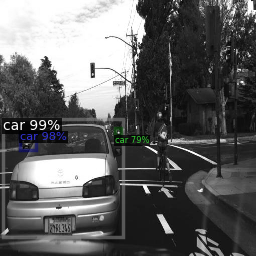

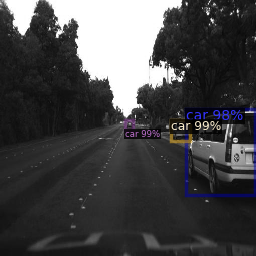

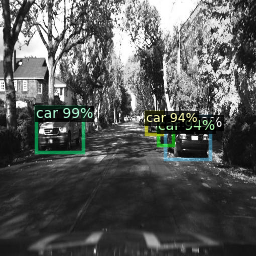

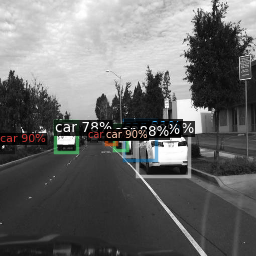

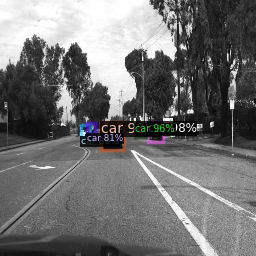

In [14]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = dataset_dict
for d in random.sample(dataset_dicts, 5):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

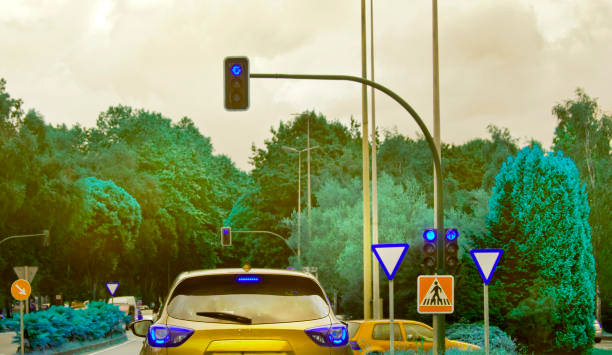

In [17]:
img=cv2.imread('/content/cR.jpg')
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
cv2_imshow(img)
outputs = predictor(img)

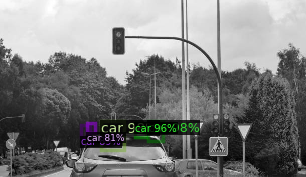

In [18]:
v = Visualizer(img[:, :, ::-1],
                   metadata=metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
out1= v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out1.get_image()[:, :, ::-1])